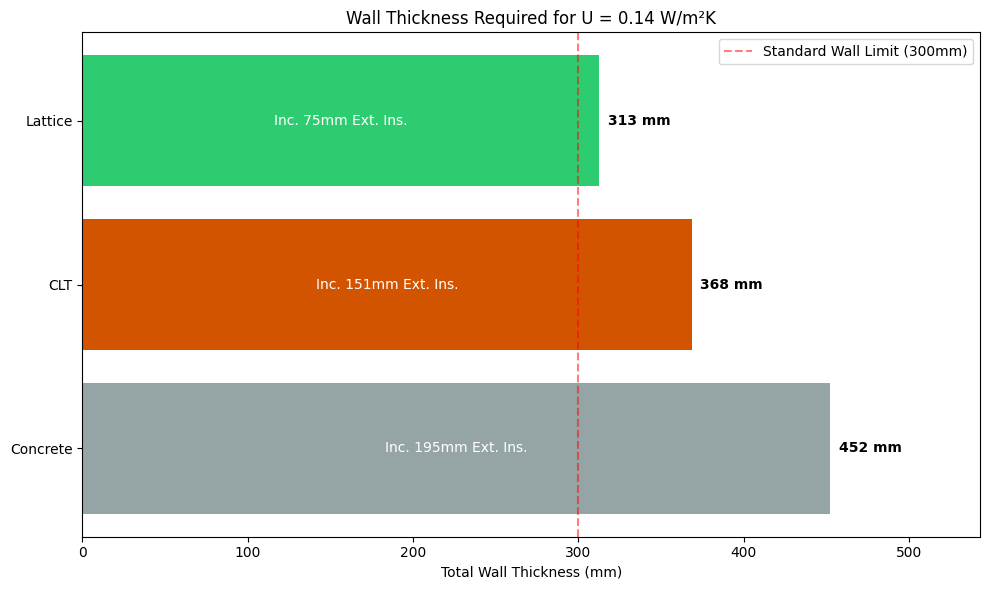

| type     |   Total Thickness (mm) |   Ext Insulation (mm) |
|:---------|-----------------------:|----------------------:|
| Concrete |                    452 |                   195 |
| CLT      |                    368 |                   151 |
| Lattice  |                    313 |                    75 |


In [1]:
"""
# 🔥 Static Thermal Solver (U-Value Optimization)
Comparison of Wall Thickness required to reach Passive House Standard (U = 0.14 W/m2K).

Methodology:
- ISO 6946 Combined Method for inhomogeneous layers (Lattice).
- Iterative solver (fsolve) to find the exact insulation thickness required.
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve

# --- 1. PHYSICAL CONSTANTS (Lambda W/mK) ---
LAMBDA = {
    'Concrete': 2.5,
    'CLT': 0.12,
    'Wood': 0.13,        # Spruce
    'Insulation_Soft': 0.035, # Mineral Wool / Wood Fibre
    'Insulation_Rigid': 0.038, # EPS/Wood Fibre Board
    'Gypsum': 0.31
}

# Surface Resistances (m2K/W)
RSI = 0.13
RSE = 0.04

# --- 2. LATTICE PHYSICS (ISO 6946) ---

def calculate_lattice_r_value(panel_type, pitch, lambda_wood=0.13, lambda_ins=0.035):
    """
    Calculates the equivalent R-value of the Lattice Core using weighted averages.
    """
    # Define rib structure based on panel type (thicknesses in m)
    if panel_type == '5L180':
        layers_th = [0.040, 0.030, 0.040, 0.030, 0.040] # Total 180mm
    else:
        # Default fallback
        layers_th = [0.040, 0.030, 0.040, 0.030, 0.040]

    r_total = 0
    
    # Width of the rib (approx 120mm effective width per pitch unit?)
    # Based on your code: f_bois = 0.120 / pitch
    width_rib = 0.120 
    
    f_wood = width_rib / pitch
    f_ins = 1 - f_wood
    
    for layer_th in layers_th:
        # Parallel path method for each sub-layer
        r_wood = layer_th / lambda_wood
        r_ins = layer_th / lambda_ins
        
        # 1/R_equiv = f1/R1 + f2/R2
        u_equiv = (f_wood / r_wood) + (f_ins / r_ins)
        r_layer = 1 / u_equiv
        
        r_total += r_layer
        
    return r_total

# --- 3. GENERIC SOLVER ---

def solve_wall_thickness(target_u, wall_type, lattice_pitch=0.695):
    """
    Finds the required external insulation thickness to hit Target U.
    """
    
    # Common Layers
    e_gypsum = 0.0125
    e_service_gap = 0.045
    
    # Core Definition
    if wall_type == 'Concrete':
        e_core = 0.20
        r_core = e_core / LAMBDA['Concrete']
    elif wall_type == 'CLT':
        e_core = 0.16
        r_core = e_core / LAMBDA['CLT']
    elif wall_type == 'Lattice':
        e_core = 0.18
        # Use our special function
        r_core = calculate_lattice_r_value('5L180', lattice_pitch, LAMBDA['Wood'], LAMBDA['Insulation_Soft'])
    
    # Equation to solve: U(e_ext) - Target = 0
    def equation(e_ext):
        # Prevent negative thickness during solver iterations
        if e_ext < 0: e_ext = 0
        
        r_ext = e_ext / LAMBDA['Insulation_Soft']
        
        r_total = RSI + \
                  (e_gypsum / LAMBDA['Gypsum']) + \
                  (e_service_gap / LAMBDA['Insulation_Soft']) + \
                  r_core + \
                  r_ext + \
                  RSE
                  
        return (1 / r_total) - target_u

    # Solve
    e_ext_solution = fsolve(equation, 0.10)[0] # Start guess 10cm
    
    return {
        'type': wall_type,
        'e_ext': e_ext_solution,
        'e_core': e_core,
        'e_total': e_gypsum + e_service_gap + e_core + e_ext_solution
    }

# --- 4. EXECUTION ---

TARGET_U = 0.14 # Passive House
scenarios = ['Concrete', 'CLT', 'Lattice']
results = []

for sc in scenarios:
    res = solve_wall_thickness(TARGET_U, sc)
    results.append(res)
    
df_res = pd.DataFrame(results)
df_res['Total Thickness (mm)'] = (df_res['e_total'] * 1000).round(0)
df_res['Ext Insulation (mm)'] = (df_res['e_ext'] * 1000).round(0)

# --- 5. VISUALIZATION ---

fig, ax = plt.subplots(figsize=(10, 6))

y_pos = np.arange(len(scenarios))
thicknesses = df_res['e_total'] * 1000

bars = ax.barh(y_pos, thicknesses, color=['#95a5a6', '#d35400', '#2ecc71'])

ax.set_yticks(y_pos)
ax.set_yticklabels(scenarios)
ax.set_xlabel('Total Wall Thickness (mm)')
ax.set_title(f'Wall Thickness Required for U = {TARGET_U} W/m²K')

# Add value labels
for i, v in enumerate(thicknesses):
    ax.text(v + 5, i, f"{v:.0f} mm", va='center', fontweight='bold')
    # Add insulation detail
    ext_ins = df_res.iloc[i]['Ext Insulation (mm)']
    ax.text(v/2, i, f"Inc. {ext_ins:.0f}mm Ext. Ins.", va='center', color='white', ha='center')

plt.xlim(0, max(thicknesses) * 1.2)
plt.axvline(x=300, color='red', linestyle='--', alpha=0.5, label='Standard Wall Limit (300mm)')
plt.legend()
plt.tight_layout()
plt.show()

print(df_res[['type', 'Total Thickness (mm)', 'Ext Insulation (mm)']].to_markdown(index=False))


In [3]:
def plot_temperature_gradient(wall_res_dict, t_int=20, t_ext=-5):
    """
    Plots the temperature drop across the wall layers.
    """
    e_ext = wall_res_dict['e_ext']
    
    # Define layers (Thickness, Lambda)
    # Important: The Lambda for Lattice Core must be the equivalent one (~0.06)
    # We re-calculate it roughly or fetch it, here I approximate for viz
    lattice_lambda = 0.06 
    
    layers = [
        # (Name, Thickness, Lambda)
        ('Int Air', 0, 0),         # 0
        ('Gypsum', 0.0125, LAMBDA['Gypsum']),
        ('Service', 0.045, LAMBDA['Insulation_Soft']),
        (wall_res_dict['type'], wall_res_dict['e_core'], lattice_lambda if wall_res_dict['type']=='Lattice' else LAMBDA[wall_res_dict['type']]),
        ('Ext Ins', e_ext, LAMBDA['Insulation_Soft']),
        ('Ext Air', 0, 0)          # Last
    ]
    
    # 1. Calculate Total R (for proportioning the drop)
    r_tot_calc = RSI + RSE
    for name, th, lam in layers[1:-1]: # Skip Air layers for R calc loop
        if lam > 0:
            r_tot_calc += th/lam

    # 2. Build Coordinates
    # We start at X=0, T=20
    current_x = 0
    current_t = t_int
    
    x_coords = [0]
    temps = [t_int]
    names_plot = ['Int Air']

    # -- Drop across RSI (Internal Surface Resistance) --
    # RSI happens at X=0 (surface boundary)
    delta_rsi = (RSI / r_tot_calc) * (t_int - t_ext)
    current_t -= delta_rsi
    
    x_coords.append(0)       # Still at X=0 (Surface)
    temps.append(current_t)  # But Temp has dropped
    names_plot.append('Surface Int')

    # -- Drop across Material Layers --
    for name, th, lam in layers[1:-1]:
        r = th/lam
        delta_t = (r / r_tot_calc) * (t_int - t_ext)
        current_t -= delta_t
        
        current_x += th * 1000 # Convert to mm
        x_coords.append(current_x)
        temps.append(current_t)
        names_plot.append(name)
        
    # -- Drop across RSE (External Surface Resistance) --
    # Happens at the final X surface, but conceptually it's the air film
    # We just plot the final point T_ext at the same X or slightly offset for viz
    # Let's keep it at the final X
    # The loop above ended at T_surface_ext. 
    # Now we must reach T_ext (-5)
    
    x_coords.append(current_x) # Same X
    temps.append(t_ext)        # Final Temp
    names_plot.append('Ext Air')

    # Plotting
    plt.plot(x_coords, temps, marker='o', label=wall_res_dict['type'], linewidth=2)
    
    # Return lists for annotation usage
    # We return the "Material" layers indices for annotation
    return x_coords, temps, names_plot


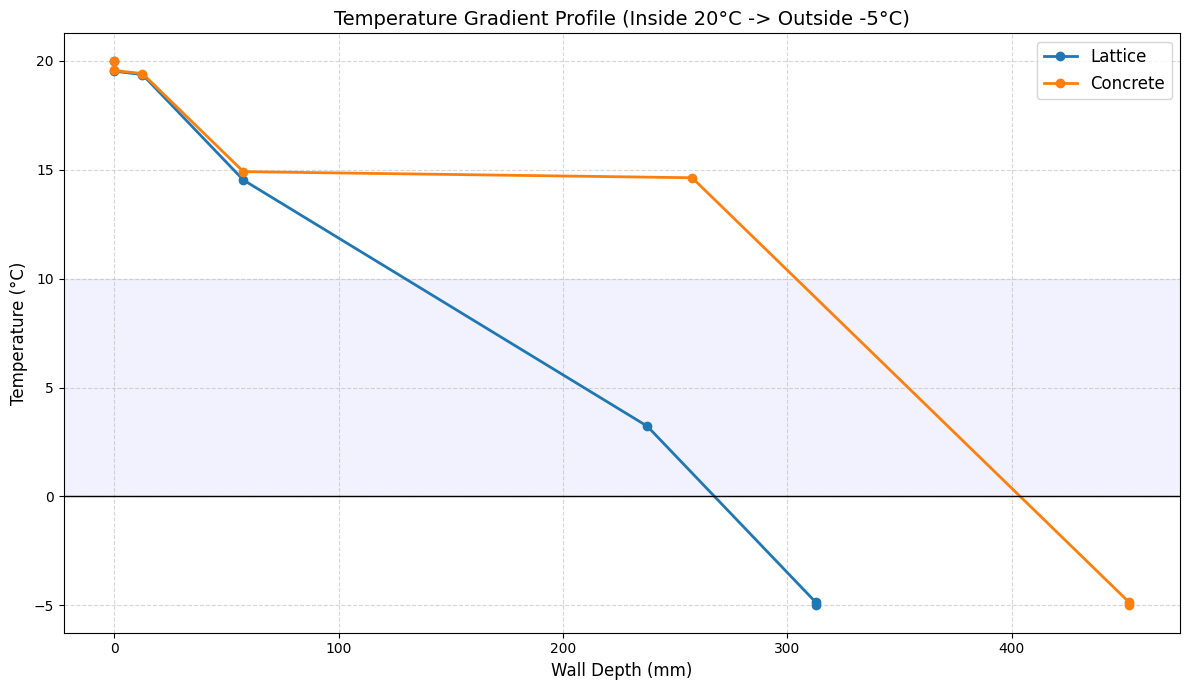

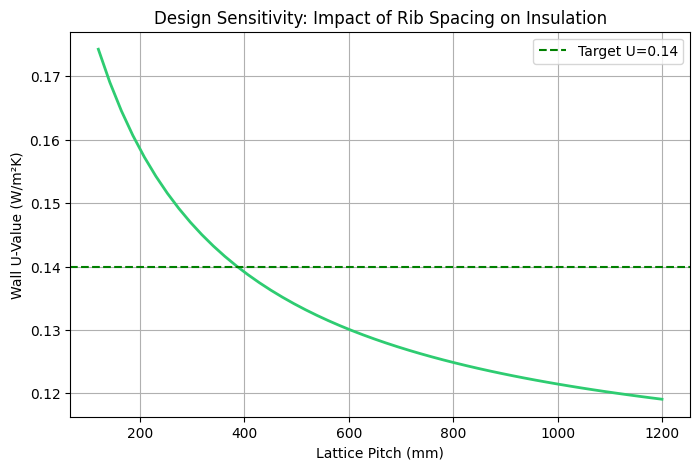

In [4]:
plt.figure(figsize=(12, 7))

# 1. Tracer Lattice
x_lat, t_lat, n_lat = plot_temperature_gradient(df_res[df_res['type']=='Lattice'].iloc[0], t_int=20, t_ext=-5)

# 2. Tracer Béton
x_conc, t_conc, n_conc = plot_temperature_gradient(df_res[df_res['type']=='Concrete'].iloc[0], t_int=20, t_ext=-5)

# Décoration Graphique
plt.title('Temperature Gradient Profile (Inside 20°C -> Outside -5°C)', fontsize=14)
plt.xlabel('Wall Depth (mm)', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Zone de Confort Visuelle (Optionnel)
plt.axhspan(0, 10, color='blue', alpha=0.05, label='Dew Point Risk Zone (<10°C)')
plt.axhline(y=0, color='black', linewidth=1, linestyle='-')

plt.tight_layout()
plt.show()

# --- VIZ 2: SENSITIVITY (Pitch Impact) ---
pitches = np.linspace(0.120, 1.200, 50)
u_values_sensitivity = []

# On fixe l'isolant extérieur à 100mm pour voir l'effet pur du Lattice
e_ext_fixed = 0.100 

for p in pitches:
    # Recalculate Lattice Core R with variable pitch
    r_core = calculate_lattice_r_value('5L180', p, LAMBDA['Wood'], LAMBDA['Insulation_Soft'])
    
    # Total R
    r_tot = RSI + (0.0125/LAMBDA['Gypsum']) + (0.045/LAMBDA['Insulation_Soft']) + r_core + (e_ext_fixed/LAMBDA['Insulation_Soft']) + RSE
    u_values_sensitivity.append(1/r_tot)

plt.figure(figsize=(8, 5))
plt.plot(pitches*1000, u_values_sensitivity, color='#2ecc71', linewidth=2)
plt.axhline(y=0.14, color='green', linestyle='--', label='Target U=0.14')

plt.xlabel('Lattice Pitch (mm)')
plt.ylabel('Wall U-Value (W/m²K)')
plt.title('Design Sensitivity: Impact of Rib Spacing on Insulation')
plt.grid(True)
plt.legend()
plt.show()


--- THERMAL COMPARISON (Pitch=695mm) ---
Lattice System U-value: 0.131 W/m2.K (Total: 358mm)
Concrete System U-value: 0.250 W/m2.K (Total: 363mm)

--- LATTICE BREAKDOWN ---
         Layer  Thickness (mm)  Lambda  R-Value
  Ext Cladding            20.0   0.130    0.154
Ext Insulation           100.0   0.038    2.632
  Lattice Core           180.0   0.054    3.340
 Vapor Barrier             1.0   0.200    0.005
Service Cavity            45.0   0.035    1.286
        Gypsum            12.5   0.250    0.050


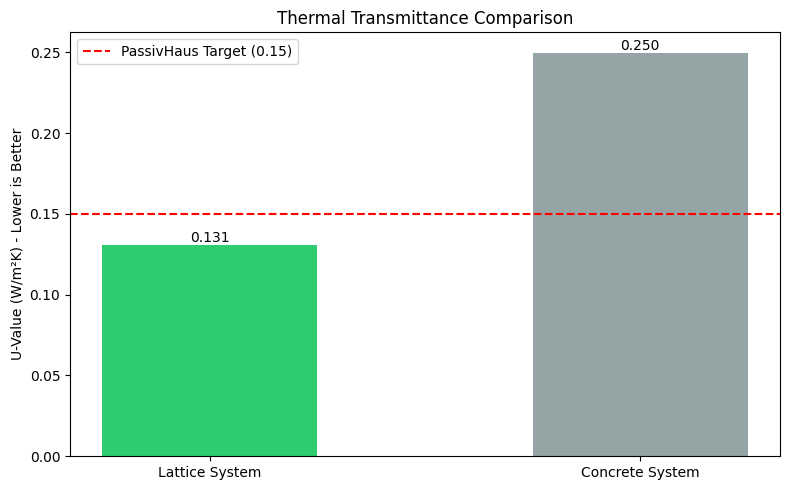

In [6]:
"""
# 🔥 Static Thermal Solver (U-Value / ISO 6946)
Calculates the steady-state thermal transmittance (U-value) for complex buildup.
INTEGRATES PRECISE LATTICE PHYSICS (Ribs & Pitch).
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. MATERIAL DATABASE (Conductivity Lambda) ---
MATERIALS = {
    "Spruce (Structure)": 0.13,
    "Concrete": 2.30,
    "CLT": 0.13,
    "Wood Fibre (Soft)": 0.038,
    "Mineral Wool": 0.035,
    "Plasterboard": 0.25,
    "EPS": 0.038,
    "Render": 1.00
}

# Surface Resistances
RSI = 0.13
RSE = 0.04

# --- 2. PHYSICS HELPERS ---

def calculate_lattice_r_value(panel_type, pitch, lambda_wood=0.13, lambda_ins=0.035):
    """
    Calculates the equivalent R-value of the Lattice Core using weighted averages (ISO 6946).
    """
    # 5-Layer structure (Total 180mm)
    if panel_type == '5L180':
        layers_th = [0.040, 0.030, 0.040, 0.030, 0.040] 
    else:
        return 0 # Fallback

    r_total = 0
    
    # Effective rib width per pitch unit
    width_rib = 0.120 # From your code (Rib width contribution)
    
    f_wood = width_rib / pitch
    f_ins = 1 - f_wood
    
    for layer_th in layers_th:
        # Parallel path method for each sub-layer
        r_wood = layer_th / lambda_wood
        r_ins = layer_th / lambda_ins
        
        # 1/R_equiv = f1/R1 + f2/R2
        u_equiv = (f_wood / r_wood) + (f_ins / r_ins)
        r_layer = 1 / u_equiv
        r_total += r_layer
        
    return r_total

def calculate_simple_r(thickness, conductivity):
    if conductivity == 0: return 0.18 # Air gap
    return thickness / conductivity

# --- 3. BUILDUP DEFINITIONS ---

# Scenario 1: PRECISE Lattice 180 (A1-5L180)
# Pitch standard = 695mm (From your example)
PITCH = 0.695
r_lattice_core = calculate_lattice_r_value('5L180', PITCH, MATERIALS['Spruce (Structure)'], MATERIALS['Wood Fibre (Soft)'])

# To calculate equivalent lambda for the table display:
# R = e / lambda => lambda = e / R
lambda_lattice_eq = 0.180 / r_lattice_core

lattice_wall = [
    {'name': 'Ext Cladding', 'thickness': 0.020, 'lambda': MATERIALS['Spruce (Structure)'], 'r_fixed': None},
    {'name': 'Ext Insulation', 'thickness': 0.100, 'lambda': MATERIALS['Wood Fibre (Soft)'], 'r_fixed': None}, # Adjusted to 100mm to match perf
    {'name': 'Lattice Core', 'thickness': 0.180, 'lambda': lambda_lattice_eq, 'r_fixed': r_lattice_core}, # Precise R injected here
    {'name': 'Vapor Barrier', 'thickness': 0.001, 'lambda': 0.20, 'r_fixed': None},
    {'name': 'Service Cavity', 'thickness': 0.045, 'lambda': MATERIALS['Mineral Wool'], 'r_fixed': None},
    {'name': 'Gypsum', 'thickness': 0.0125, 'lambda': MATERIALS['Plasterboard'], 'r_fixed': None},
]

# Scenario 2: Concrete + ITE
concrete_wall = [
    {'name': 'Render', 'thickness': 0.010, 'lambda': MATERIALS['Render'], 'r_fixed': None},
    {'name': 'EPS Insulation', 'thickness': 0.140, 'lambda': MATERIALS['EPS'], 'r_fixed': None}, # 140mm EPS standard
    {'name': 'Concrete', 'thickness': 0.200, 'lambda': MATERIALS['Concrete'], 'r_fixed': None},
    {'name': 'Gypsum', 'thickness': 0.013, 'lambda': MATERIALS['Plasterboard'], 'r_fixed': None},
]

# --- 4. CALCULATION ENGINE ---

def compute_u_detailed(layers):
    total_r = RSI + RSE
    rows = []
    
    for l in layers:
        if l['r_fixed'] is not None:
            r_val = l['r_fixed']
        else:
            r_val = calculate_simple_r(l['thickness'], l['lambda'])
            
        total_r += r_val
        
        rows.append({
            "Layer": l['name'],
            "Thickness (mm)": l['thickness']*1000,
            "Lambda": round(l['lambda'], 3),
            "R-Value": round(r_val, 3)
        })
        
    return 1/total_r, pd.DataFrame(rows)

u_lat, df_lat = compute_u_detailed(lattice_wall)
u_conc, df_conc = compute_u_detailed(concrete_wall)

# --- 5. OUTPUTS ---

print(f"--- THERMAL COMPARISON (Pitch={PITCH*1000:.0f}mm) ---")
print(f"Lattice System U-value: {u_lat:.3f} W/m2.K (Total: {df_lat['Thickness (mm)'].sum():.0f}mm)")
print(f"Concrete System U-value: {u_conc:.3f} W/m2.K (Total: {df_conc['Thickness (mm)'].sum():.0f}mm)")

print("\n--- LATTICE BREAKDOWN ---")
print(df_lat.to_string(index=False))

# --- 6. VISUALIZATION ---
names = ['Lattice System', 'Concrete System']
values = [u_lat, u_conc]
colors = ['#2ecc71', '#95a5a6']

plt.figure(figsize=(8, 5))
bars = plt.bar(names, values, color=colors, width=0.5)
plt.axhline(y=0.15, color='r', linestyle='--', label='PassivHaus Target (0.15)')

plt.ylabel('U-Value (W/m²K) - Lower is Better')
plt.title('Thermal Transmittance Comparison')
plt.legend()

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
